In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [2]:
def generate_key_matrix_from_image(image_path, size=16, distance=10):
    """Generate a 16x16 key matrix from an image with non-repeating and spaced values."""
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise ValueError(f"Unable to load image from {image_path}.")
    
    # Flatten the image and extract pixel values
    flat_values = img.flatten()
    pixel_values = []
    seen_values = set()
    
    # Collect unique pixel values with distance constraint
    for i in range(0, len(flat_values), distance):
        value = flat_values[i]
        if value not in seen_values:
            pixel_values.append(value)
            seen_values.add(value)
    
    # Fill with remaining values to reach 256 unique entries
    all_values = np.arange(256)
    missing_values = np.setdiff1d(all_values, pixel_values)
    pixel_values.extend(missing_values[:256 - len(pixel_values)])
    
    # Convert to numpy array and shuffle
    key_values = np.array(pixel_values)
    np.random.seed(42)  # For reproducibility
    np.random.shuffle(key_values)
    
    # Create key matrix
    key_matrix = key_values.reshape((size, size))
    
    return key_matrix

In [3]:
def encrypt_decrypt_plane_with_key(plane, key_matrix, operation='encrypt'):
    """Encrypt or decrypt an image plane using Playfair-like rules with the key matrix."""
    height, width = plane.shape
    transformed_plane = np.zeros((height, width), dtype=np.uint8)
    
    key_size = key_matrix.shape[0]

    # Create a reverse key matrix for decryption
    reverse_key_matrix = np.zeros_like(key_matrix)
    for i in range(key_size):
        for j in range(key_size):
            value = key_matrix[i, j]
            reverse_key_matrix[value // key_size, value % key_size] = i * key_size + j
    
    def find_position(value):
        """Find the (row, col) of a value in the key matrix."""
        row, col = np.where(key_matrix == value)
        return row[0], col[0]

    def transform_value(value, operation):
        """Transform a single pixel value based on the key matrix and operation."""
        row, col = find_position(value)
        
        if operation == 'encrypt':
            if row == row:  # Same row
                new_col = (col + 1) % key_size
                return key_matrix[row, new_col]
            elif col == col:  # Same column
                new_row = (row + 1) % key_size
                return key_matrix[new_row, col]
        elif operation == 'decrypt':
            if row == row:  # Same row
                new_col = (col - 1) % key_size
                return key_matrix[row, new_col]
            elif col == col:  # Same column
                new_row = (row - 1) % key_size
                return key_matrix[new_row, col]
        else:
            raise ValueError("Operation must be 'encrypt' or 'decrypt'.")
    
    # Process each pixel in the plane
    for y in range(height):
        for x in range(width):
            pixel_value = plane[y, x]
            transformed_plane[y, x] = transform_value(pixel_value, operation)
    
    return transformed_plane

In [4]:
def encrypt_image_with_key(image, key_matrix):
    """Encrypt the image using the key matrix."""
    height, width, channels = image.shape
    encrypted_image = np.zeros_like(image)
    
    for ch in range(channels):
        color_plane = image[:, :, ch]
        encrypted_plane = encrypt_decrypt_plane_with_key(color_plane, key_matrix, 'encrypt')
        encrypted_image[:, :, ch] = encrypted_plane
    
    return encrypted_image

In [5]:
def decrypt_image_with_key(encrypted_image, key_matrix):
    """Decrypt the image using the key matrix."""
    height, width, channels = encrypted_image.shape
    decrypted_image = np.zeros_like(encrypted_image)
    
    for ch in range(channels):
        color_plane = encrypted_image[:, :, ch]
        decrypted_plane = encrypt_decrypt_plane_with_key(color_plane, key_matrix, 'decrypt')
        decrypted_image[:, :, ch] = decrypted_plane
    
    return decrypted_image

In [6]:
def display_images(original, encrypted, decrypted, key_matrix):
    """Display the original, encrypted, decrypted images and key matrix."""
    plt.figure(figsize=(24, 8))
    
    plt.subplot(1, 4, 1)
    plt.title('Original Image')
    plt.imshow(original)
    plt.axis('off')
    
    plt.subplot(1, 4, 2)
    plt.title('Encrypted Image')
    plt.imshow(encrypted)
    plt.axis('off')
    
    plt.subplot(1, 4, 3)
    plt.title('Decrypted Image')
    plt.imshow(decrypted)
    plt.axis('off')
    
    plt.subplot(1, 4, 4)
    plt.title('Key Matrix')
    plt.imshow(key_matrix, cmap='viridis')
    plt.colorbar()
    plt.axis('off')
    
    plt.show()

In [7]:
def main_process(image_path, key_image_path):
    """Main process to load, encrypt, decrypt, and display images."""
    key_size = 16
    
    # Generate the key matrix from the key image
    key_matrix = generate_key_matrix_from_image(key_image_path, size=key_size)
    
    # Print the key matrix
    print("Generated Key Matrix:")
    print(key_matrix)
    
    # Load and prepare the image
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
    
    # Encrypt the image
    encrypted_img = encrypt_image_with_key(img_rgb, key_matrix)
    
    # Decrypt the image
    decrypted_img = decrypt_image_with_key(encrypted_img, key_matrix)
    
    # Display images and key matrix
    display_images(img_rgb, encrypted_img, decrypted_img, key_matrix)

Generated Key Matrix:
[[215  32 139 180 144 200 237 170  76  24 198   0 213 235   2 115]
 [181  40 138  50 242  60 100 157  37 119 253 228   8 183 154 126]
 [120 187 223  53  70  83 209 122 163 160 232 196  34  16  64 134]
 [218 190 121  58 113  14 123 204 137 151   3  68 132 177 247  94]
 [236  98  92 189  59  84 171  17 142  88 135 241 143 244  63  39]
 [158  66  90  52 106 105 116 169  74 202  67 225 245  18  35  51]
 [ 45  55 127  47 147 148 185 251  38 238 130  95 221  20  69  97]
 [166  13 149  42 246 161  99 165 102  10  26   5  72 131 192 184]
 [173 254  65  23  77 194 109   9 250 212  48 229  30 146  21  96]
 [193 117 114 128 112 239 167  85 164  19  22 155 176  49 111 172]
 [ 44 168 249  86  78   1  57 110 175 182  61 125 188  29 124  71]
 [107 230 178 240  62 150   7  46 206  41 156 207 104  36  91 214]
 [243  89  43  31  27 222 136  79 179  80 216  93 208 227 226   6]
 [140 233 205 191 231 197 252 210 219 159  28 217  25 133  56  12]
 [211 186 248 203 152 103  81 153 234  1

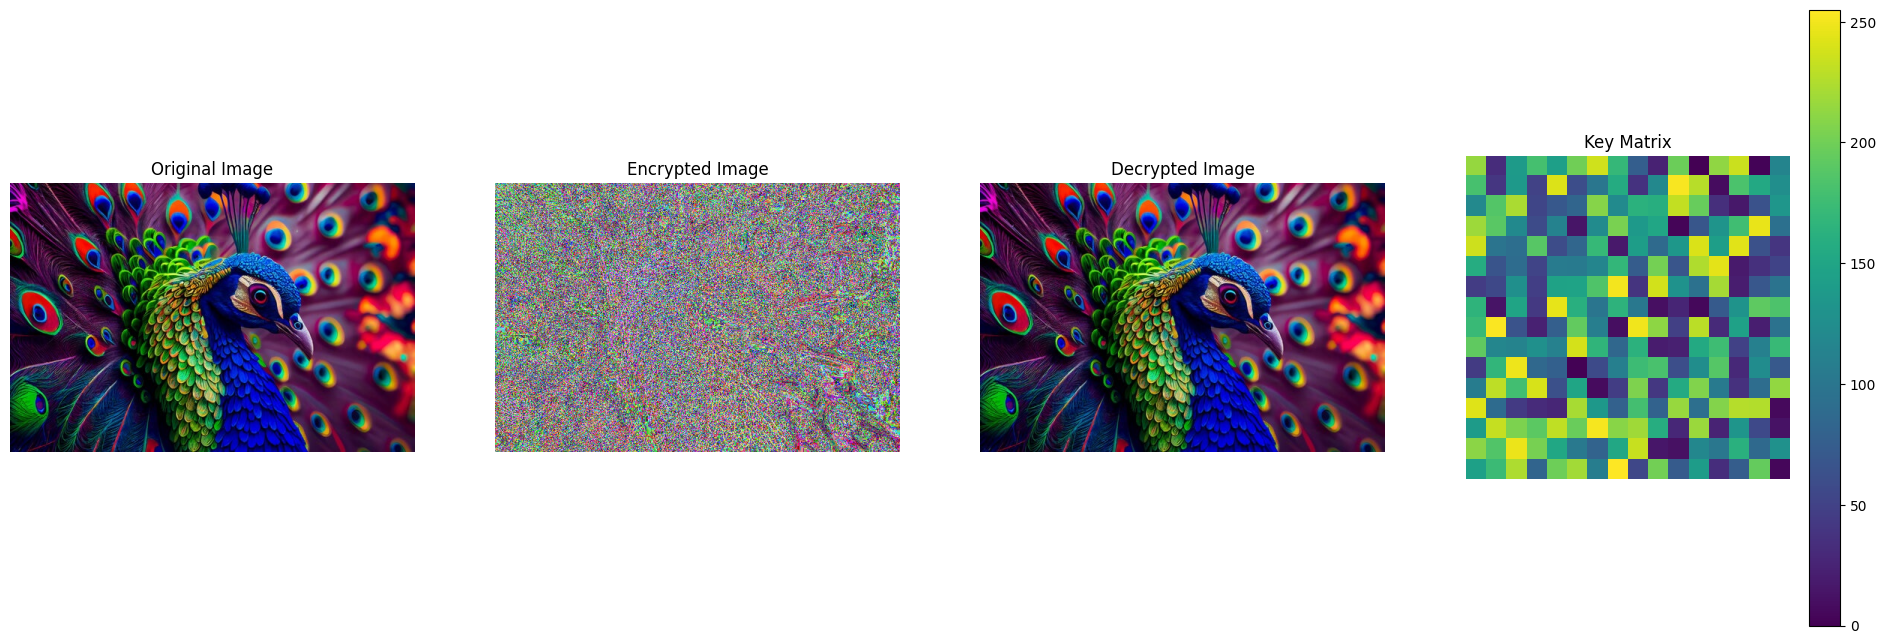

In [12]:
key_image_path = "girgit.jpg"
image_path = "peacock image.jpg"   
main_process(image_path, key_image_path)


Generated Key Matrix:
[[221   3  51 213 160 185 240 178  66  47 175 210 224 249   0   2]
 [201 118 174  82 232  75 139 121  86 137 253 222 129 120 172  94]
 [157 193 207  45  90  79 113  61 205 183 237 152  18  73 101  20]
 [236 209 150  71 143 184  57 208  89  58 119  53 141 163 244  93]
 [220  99 145 144  55 159 148   4 111 112   7 245  91 241  77  10]
 [194 158  78  26  83  97 140 154  88 186 103 212 234  23  54 190]
 [ 17  32 117  31 107 105 200 251 115 238 108 123 192 156  27  15]
 [133  76 125   8 246 177 136 196 142  63  16  69  56 122 211 165]
 [164 254   6 102  87 197 132  50 250 228  39 225  11  40  30 135]
 [179 151 155  72 138 227 199  21 206  52  24 170 146  38  60 126]
 [ 48 195 248  96  85 243 109 110 203 124   9 134 198   1  98  74]
 [131 229 204 235  43 127  67 153 218  25 182 242 171  12  81 223]
 [231  19  41  42  37 202  68  59 162  36 216 147 214 233 188  80]
 [ 35 116 230 161 226 167 252 215 219 181  13 191  33  28  29  34]
 [173  92 247 187 189 100  44  84 239  4

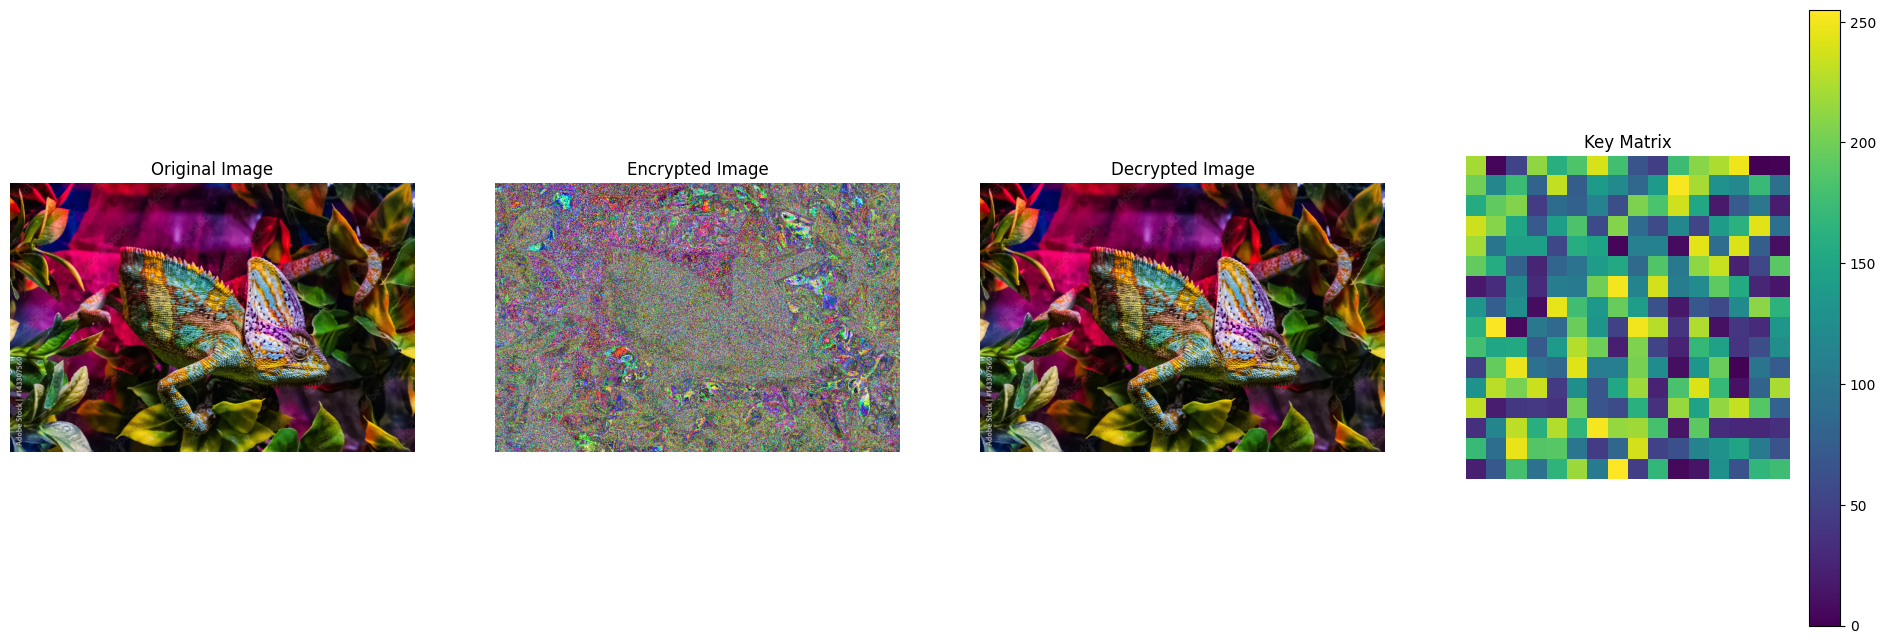

In [13]:
key_image_path = "peacock image.jpg"
image_path = "girgit.jpg"   
main_process(image_path, key_image_path)

Generated Key Matrix:
[[ 30 254  83   8 129 144  44 237 190 174 170  24  32  19  75 219]
 [  1  77 134 112  37  98  63 195 189  80  56  10 113  69 165 162]
 [215 241  25 120 227 167 228 125 245 235  41 145 104 114 156 142]
 [ 17   3  70  87 206 172 117  22 205 197 239 103  76 184  47 183]
 [ 27 148  91 231 248  73  89 121 140 158 220  48  72  45 232 110]
 [182 212  61 177 149 199 181 147 106 150 230  21  39  97 175  85]
 [204 126  67 161  65 242 153  53  93  42 202 159   6 229 166  59]
 [193 101 152 128  49 139  64 132 213 255 252 102 115  99   7 194]
 [168  57 226 154 100   2 244 211  52  26 108  33 250 217 146 192]
 [191 187  68  86 216  34  60  81 240 249 178 200 233 109 201 188]
 [246 137  51 222 198  46 160 223 238 123 171  84  55 251 221 143]
 [218  35   0  40 135  92 176 196  13 127 133  18 236  82  90  31]
 [ 36  58 208  96  94  23 214  95 122 138  28  79  11  38 151 111]
 [ 78 173  14  71  15 131  54   9  29 136 130  20 116 180 119 124]
 [  5 155  50 141  74  66 185 209  43 25

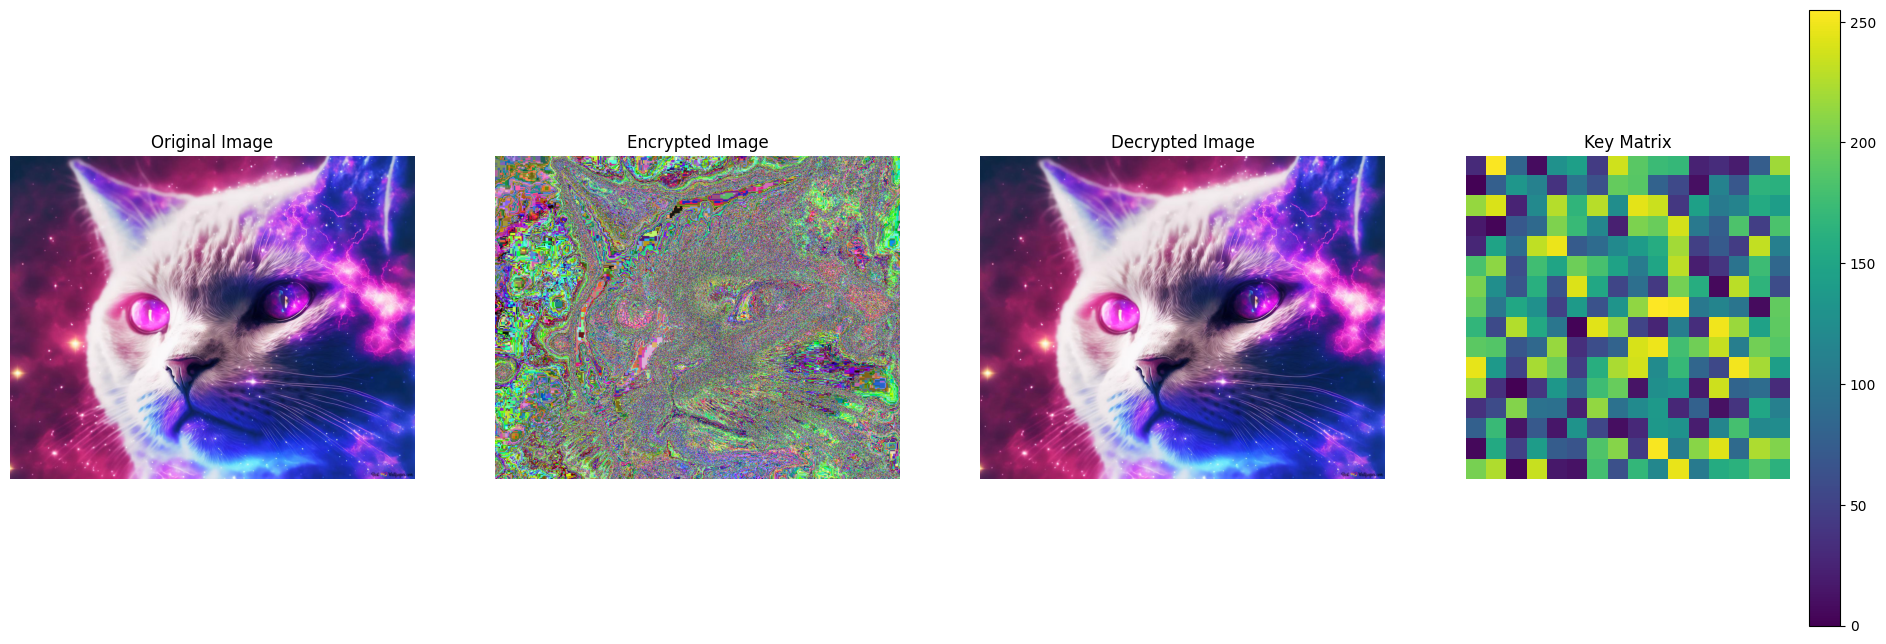

In [15]:
key_image_path = "banana.jpg"
image_path = "billi.jpg"   
main_process(image_path, key_image_path)

Generated Key Matrix:
[[ 30 254  83   8 129 144  44 237 190 174 170  24  32  19  75 219]
 [  1  77 134 112  37  98  63 195 189  80  56  10 113  69 165 162]
 [215 241  25 120 227 167 228 125 245 235  41 145 104 114 156 142]
 [ 17   3  70  87 206 172 117  22 205 197 239 103  76 184  47 183]
 [ 27 148  91 231 248  73  89 121 140 158 220  48  72  45 232 110]
 [182 212  61 177 149 199 181 147 106 150 230  21  39  97 175  85]
 [204 126  67 161  65 242 153  53  93  42 202 159   6 229 166  59]
 [193 101 152 128  49 139  64 132 213 255 252 102 115  99   7 194]
 [168  57 226 154 100   2 244 211  52  26 108  33 250 217 146 192]
 [191 187  68  86 216  34  60  81 240 249 178 200 233 109 201 188]
 [246 137  51 222 198  46 160 223 238 123 171  84  55 251 221 143]
 [218  35   0  40 135  92 176 196  13 127 133  18 236  82  90  31]
 [ 36  58 208  96  94  23 214  95 122 138  28  79  11  38 151 111]
 [ 78 173  14  71  15 131  54   9  29 136 130  20 116 180 119 124]
 [  5 155  50 141  74  66 185 209  43 25

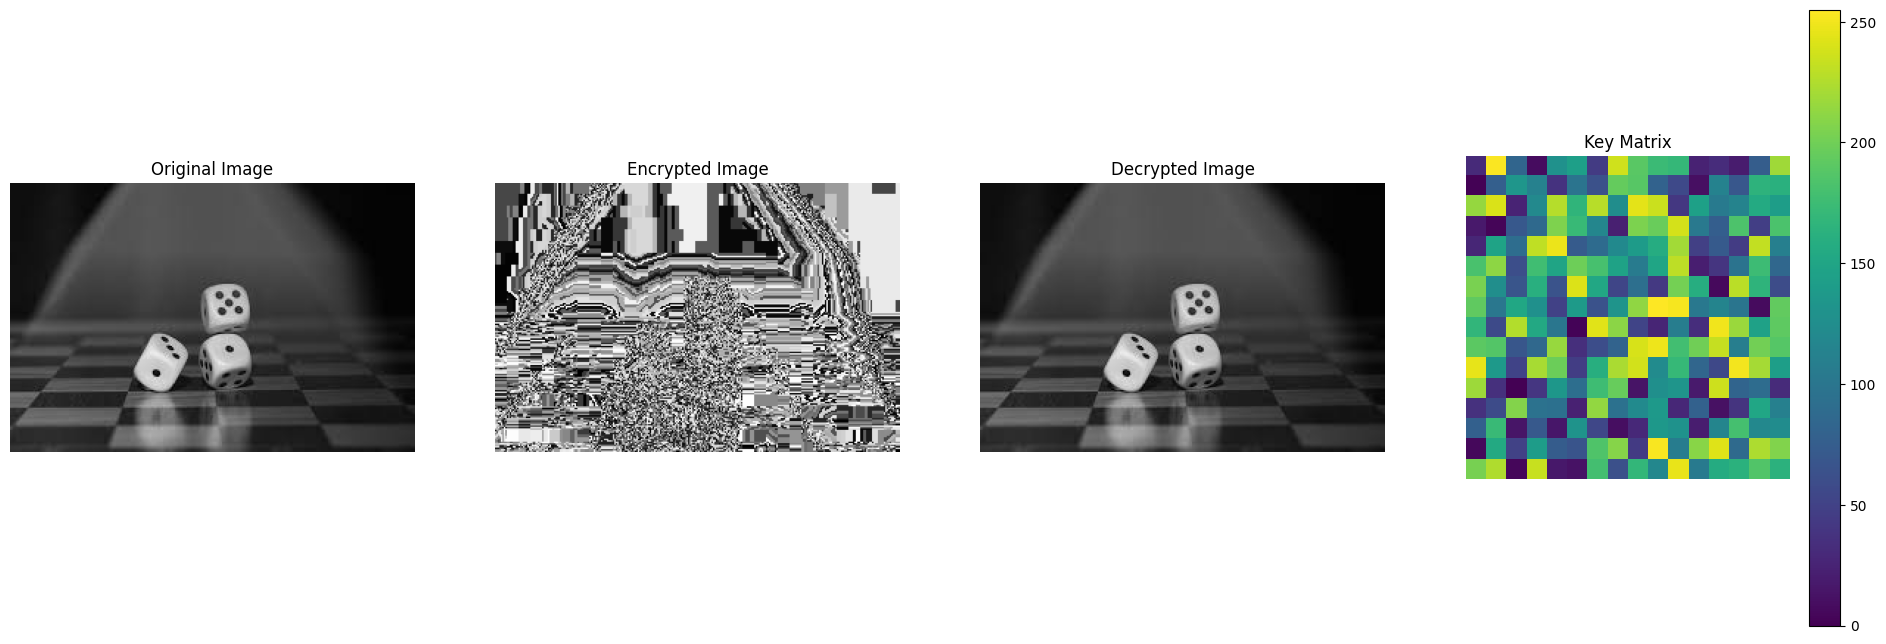

In [10]:
key_image_path = "banana.jpg"
image_path = "dice1.jpg"   
main_process(image_path, key_image_path)

Generated Key Matrix:
[[ 96   0 190  64  80  69 195 229  21 130 241  53 110  18 199 153]
 [ 95 183 128 157 145  76  49 113 162  42 240  81  41  58 246  24]
 [238 102  60   2  47  16 205  59 224  90 174 242 164 147 156 142]
 [  4  51 108  13  99 186  52  39  66  48  85  10 135  83 209 226]
 [ 74  77  36 231 150 247 206 233  57 129 191 216  30 202 140 192]
 [211 146 200   7 198 121 215 208 197 228  27  32 159 177 184  98]
 [ 23 120  87 154 126 175 109 236  50 181 193  35  86 176  33 106]
 [222 148  84 160 218 253 182 105  40  17  20   5 165 133  43 217]
 [245 244 137 179 250  92 194 170 234  67 168 117   8 127 173 125]
 [214 248 107 116  72 124 210 187  97 155 180 100 249  12 204 225]
 [163 207 230 151 189 203   1 185 101 213 144 115 111  15   6 166]
 [ 79 131  73 167 171 232  26 161  63 136 220  11 132  22  70 103]
 [138  31  65  14  93  46  37 149 112 141  82 119  56 152 178 255]
 [ 28  54  71 219  45  78 237  61  89 251 254  25 212 143 158 172]
 [ 62 227 223 239  75 122   9 114 188  1

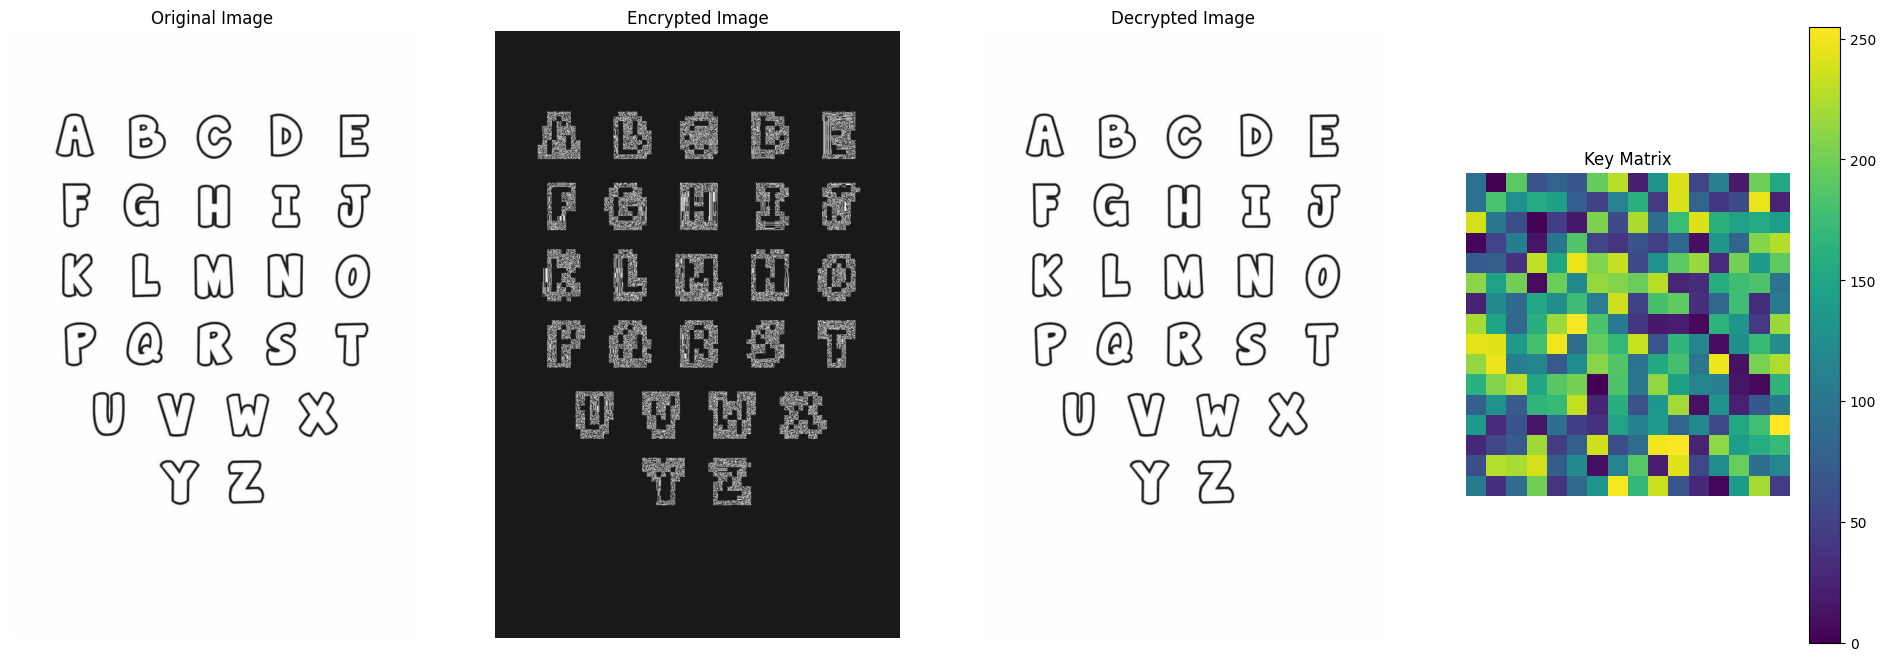

In [19]:
key_image_path = "die2.jpg"
image_path = "words.jpg"   
main_process(image_path, key_image_path)

Generated Key Matrix:
[[146 251  89 160 131 137 101  92 248 184 170 132  67  52 126  43]
 [136 167 226  29 149  15 232  95   0  90 161 128 236  13 195 202]
 [127 196 205  51  44 162 102  63 231 199 139 116 138 241 123  56]
 [105  40 176  32  48   1  55 141 113 209  14 219  65 208 106 215]
 [177 142 129 190  73  75  21 172 224 100  24 118 238 197  18 194]
 [120  98 182 104 201  72 121  41  28 233 165 210  30  12 217   8]
 [246 103 200  39  76 181 166 158 193 179  87  50 164   6   2 110]
 [175  79  70   3  46  68 180  81  42 255 252  22 144  11 229  36]
 [114 153  77 245 242  64 163  17 112 186  99 183 253 223 188 150]
 [198 151 220  23  58 168  82 216 230  60  20 207  91  86  47  34]
 [ 33  38  80  96 243  27 143  97  45 145  10 214  54 250 240  35]
 [ 59 204 159 107 148  62 171   5  61 249 222  53 227 173 185  49]
 [178 221 247  19 235 206 140  16  78 122 203 108 228 125 225   9]
 [109 192  88 152  74 117 154 169 174 155  93  69 213  83   4  71]
 [211 134 133 115  37 111 130 187  66 25

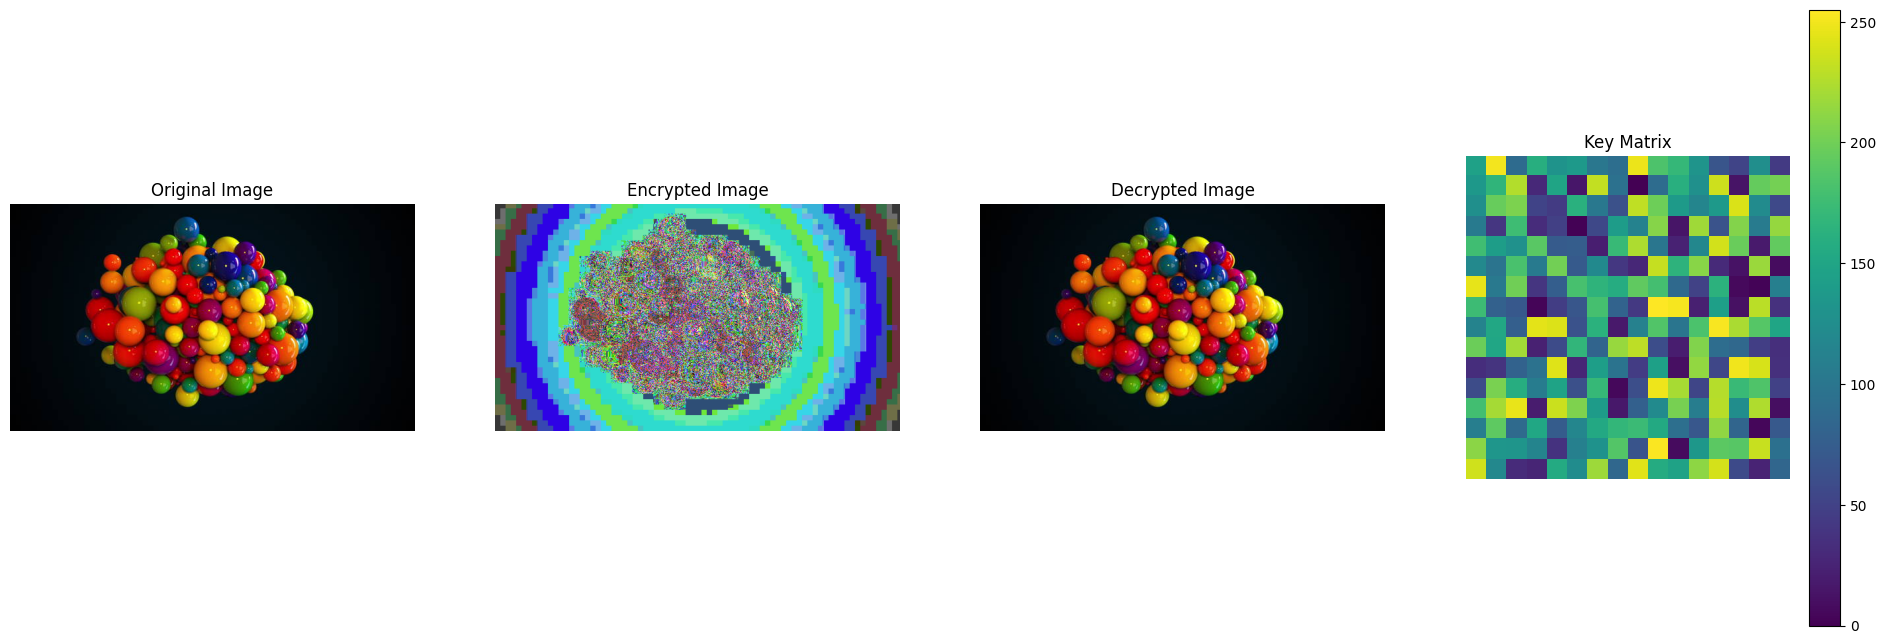

In [20]:
key_image_path = "words2.jpg"
image_path = "gems.jpg"   
main_process(image_path, key_image_path)

Generated Key Matrix:
[[203 197 247 151 112 102 231  55 173 134  89 191 212 184  16 233]
 [135  57  11  93 219  64 157  35  78   0 248 155 234  51  99 136]
 [ 30 111 192  82 129  85  63  17 125  80 226  91  56 116 132 170]
 [175 139  83  61  24 100 140 189  19  20   4 201  88  72 237   2]
 [199  25 160  84 167 194  41 113  22  68  95 238 209 232   9 154]
 [ 69  50 105 185 182  12  37  46 205 104 156 188 222 123 240 165]
 [124  81 169 133   1 229  73 245 251 227  48  27 149 207 174 210]
 [ 38 126  33  29 239  66 183 120  21 254 255  76 196 147 150  43]
 [ 98 249 176  94 148 138  23  65 244 195 235 213 168 119 252  28]
 [ 96  18 242  15   5 216 121 177 130 106 178  52  39  47 127  36]
 [179 115 243  92 204 236 215 193 122  45  54  26  77 187  79  90]
 [ 13 217 131 225 230  49  97 221 162 152  70 180 118 158 107 211]
 [218 142 214  75 181 190  10 128  53 198 200  14 159 220 172 223]
 [ 42  31 163  74 164 110 246 153 202  67 117 186 144 206  58 101]
 [145  44 241 108 114   6  71  40 228 25

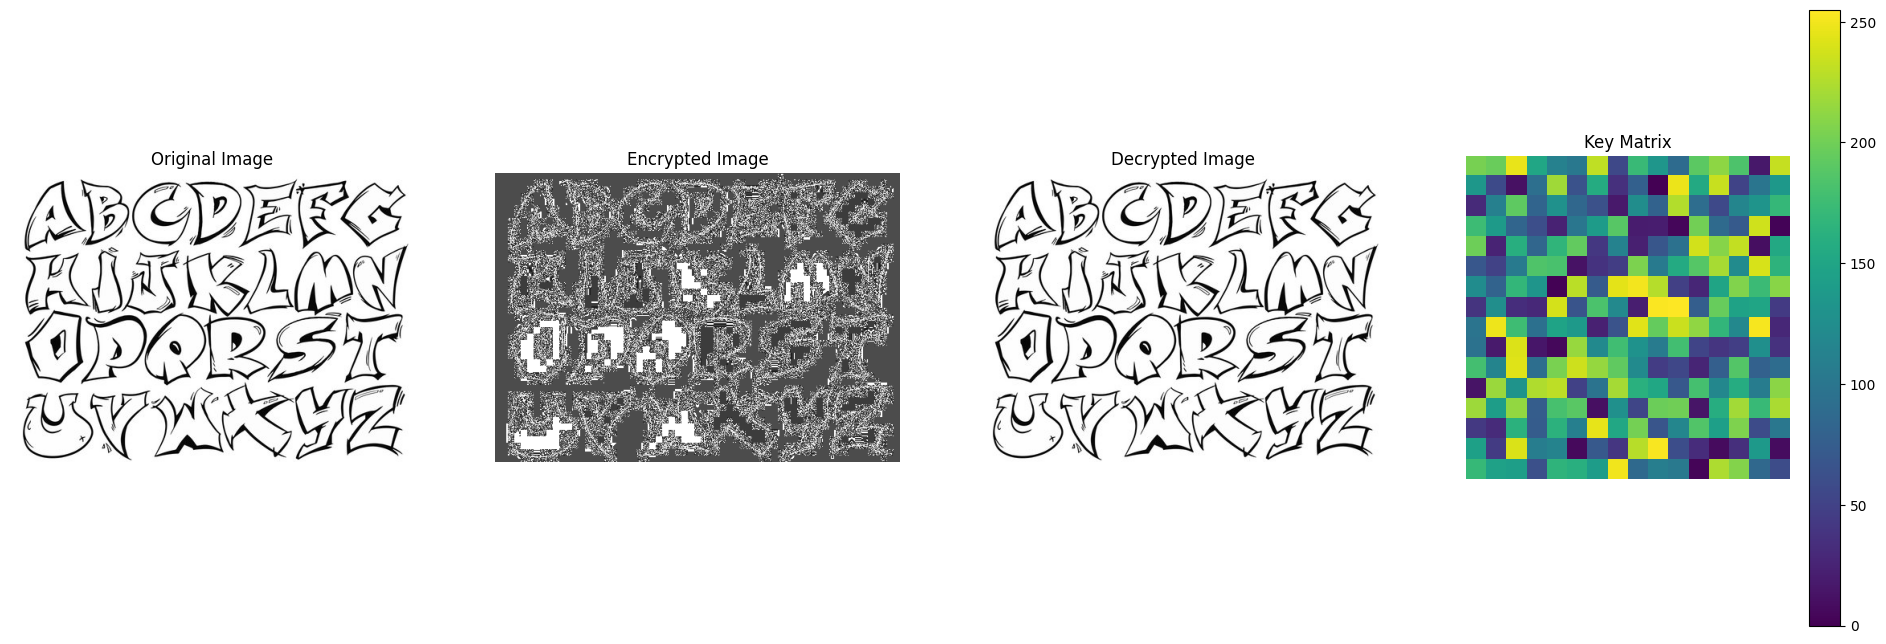

In [21]:
key_image_path = "words3.jpg"
image_path = "words2.jpg"   
main_process(image_path, key_image_path)

Generated Key Matrix:
[[210   8 168 200 143 140 194  74  12  39 162 180 214 244  88  67]
 [183  62  94  43 181  77 204 155 198 173 245 185  13 164 141 116]
 [ 66 227 251  85 103  46 153 148 219  70 177  96 232 115  48  30]
 [199 172 133 123 158 163 109 237  31 125 192  80 235 146 240 189]
 [222 197 224 165  82 108 113  97 100  21 106 238 218 170 215  44]
 [ 95 137 118   7  16  71  29  91  58 211 156 208 233  47  17 136]
 [ 84 104 161  69 102 234  23 236 114 209  22  36 241   0  68 151]
 [122  99 178  53 247  24 119 250  83   1   3   5  59 191 169 179]
 [144 246 142  79  89 202 139  10 203 228  50 223   6 110  64 126]
 [159 216  35 145  32 186  87  18 206  28  61 154  86  51 175 166]
 [ 14 212 205 160  42 231  75 195 128 149  49  34 253   4  57 117]
 [138 220 111 249  41  33 147  54 182   9  93 201 101  37 127 229]
 [230 150  11  52  56 252 225  76 152 129 221 131 193 196  73  40]
 [174  55 226 171 207  78 239 188 217 176  65 243  92  63  45  72]
 [213 107 242 105 255 121  19 157 254   

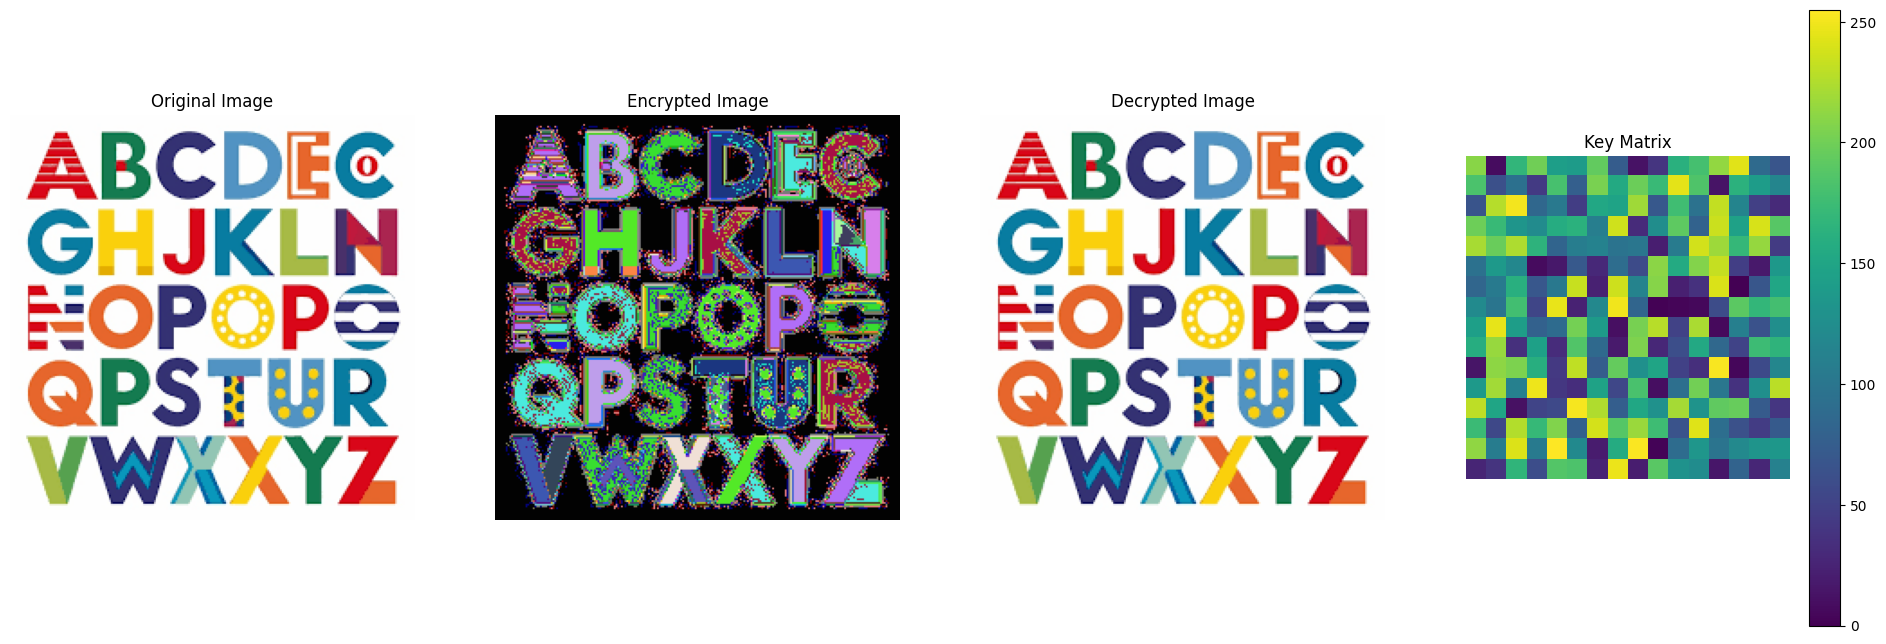

In [22]:
key_image_path = "gems.jpg"
image_path = "words3.jpg"   
main_process(image_path, key_image_path)

Generated Key Matrix:
[[203 197 247 151 112 102 231  55 173 134  89 191 212 184  16 233]
 [135  57  11  93 219  64 157  35  78   0 248 155 234  51  99 136]
 [ 30 111 192  82 129  85  63  17 125  80 226  91  56 116 132 170]
 [175 139  83  61  24 100 140 189  19  20   4 201  88  72 237   2]
 [199  25 160  84 167 194  41 113  22  68  95 238 209 232   9 154]
 [ 69  50 105 185 182  12  37  46 205 104 156 188 222 123 240 165]
 [124  81 169 133   1 229  73 245 251 227  48  27 149 207 174 210]
 [ 38 126  33  29 239  66 183 120  21 254 255  76 196 147 150  43]
 [ 98 249 176  94 148 138  23  65 244 195 235 213 168 119 252  28]
 [ 96  18 242  15   5 216 121 177 130 106 178  52  39  47 127  36]
 [179 115 243  92 204 236 215 193 122  45  54  26  77 187  79  90]
 [ 13 217 131 225 230  49  97 221 162 152  70 180 118 158 107 211]
 [218 142 214  75 181 190  10 128  53 198 200  14 159 220 172 223]
 [ 42  31 163  74 164 110 246 153 202  67 117 186 144 206  58 101]
 [145  44 241 108 114   6  71  40 228 25

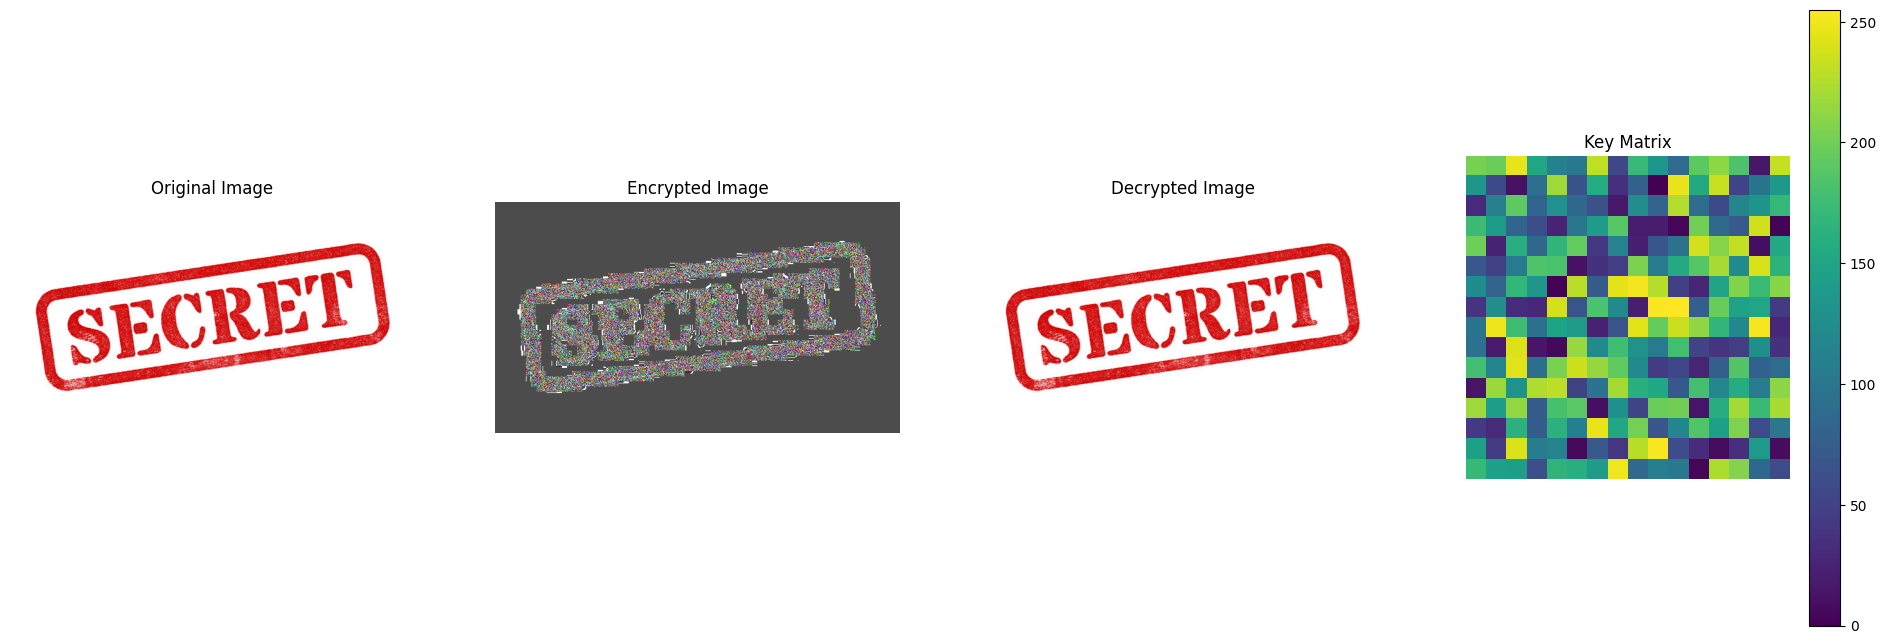

In [23]:
key_image_path = "words3.jpg"
image_path = "secret.jpg"   
main_process(image_path, key_image_path)

Generated Key Matrix:
[[ 15 124 141 197  86  65  33 212 104  89  51  35  28  44  58 152]
 [238  94 174 107  27  93 126 208 137 171   7 175  78 217  73 169]
 [173 182   2  98 186 105 128  59  53  43  31  70 103  97 129 163]
 [225 190  47 110  61 158  88  40 183  62 244 130 156  71  19 228]
 [ 37  79 144  52 145  87 236 109  68 150 201  14 118  10 172 122]
 [ 66 210 251 159 115  81 207 246 151 245 133  41  16 111 223 120]
 [241 234 229 117 184 138  49   5 113  25 125 248 219 242 196 147]
 [227 148 185 102  18  39 200  64 178   0 177 176 161 247 192 179]
 [ 46   8 140 191 114 180  80 132   4  36 215  29 255 253 254 240]
 [ 75  82  96  69  85  13 220 187 188 139 121 198 211  95 249 195]
 [189 237   3 250 112  12 235 135 202 199 243 157  74 222 170 214]
 [231  32 194  26  92 233 108 164  55 193  50  45 127 165 160  30]
 [ 22 116 226 101 146  21 221 119  42 143  11  76  54  20 168 123]
 [153 106  83  60  56 224   6 181  23  63 166  38 136 134  90 252]
 [206 204   1   9  34 205 218 232  17 23

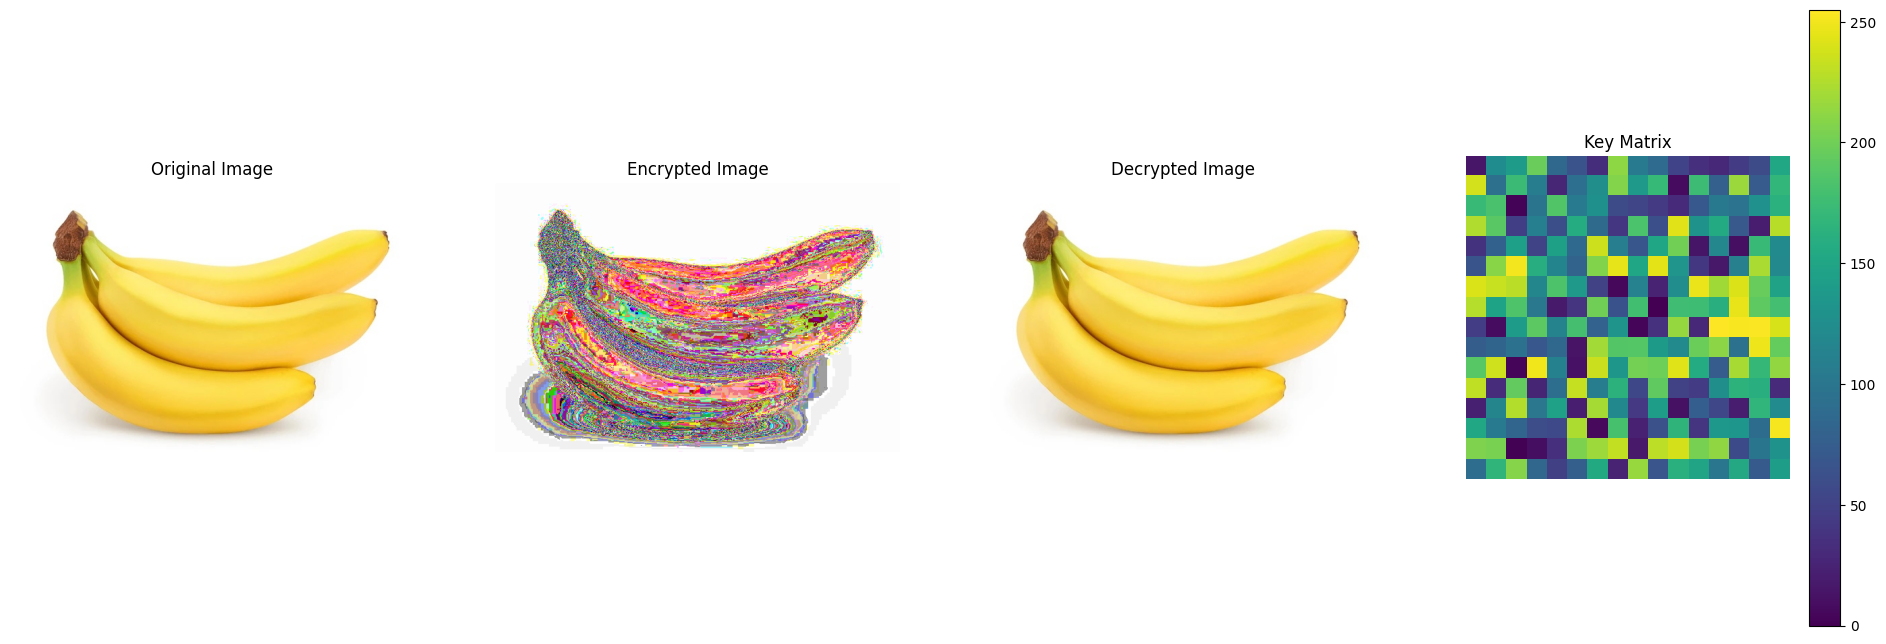

In [24]:
key_image_path = "apple.jpg"
image_path = "banana.jpg"   
main_process(image_path, key_image_path)

Generated Key Matrix:
[[215  32 139 180 144 200 237 170  76  24 198   0 213 235   2 115]
 [181  40 138  50 242  60 100 157  37 119 253 228   8 183 154 126]
 [120 187 223  53  70  83 209 122 163 160 232 196  34  16  64 134]
 [218 190 121  58 113  14 123 204 137 151   3  68 132 177 247  94]
 [236  98  92 189  59  84 171  17 142  88 135 241 143 244  63  39]
 [158  66  90  52 106 105 116 169  74 202  67 225 245  18  35  51]
 [ 45  55 127  47 147 148 185 251  38 238 130  95 221  20  69  97]
 [166  13 149  42 246 161  99 165 102  10  26   5  72 131 192 184]
 [173 254  65  23  77 194 109   9 250 212  48 229  30 146  21  96]
 [193 117 114 128 112 239 167  85 164  19  22 155 176  49 111 172]
 [ 44 168 249  86  78   1  57 110 175 182  61 125 188  29 124  71]
 [107 230 178 240  62 150   7  46 206  41 156 207 104  36  91 214]
 [243  89  43  31  27 222 136  79 179  80 216  93 208 227 226   6]
 [140 233 205 191 231 197 252 210 219 159  28 217  25 133  56  12]
 [211 186 248 203 152 103  81 153 234  1

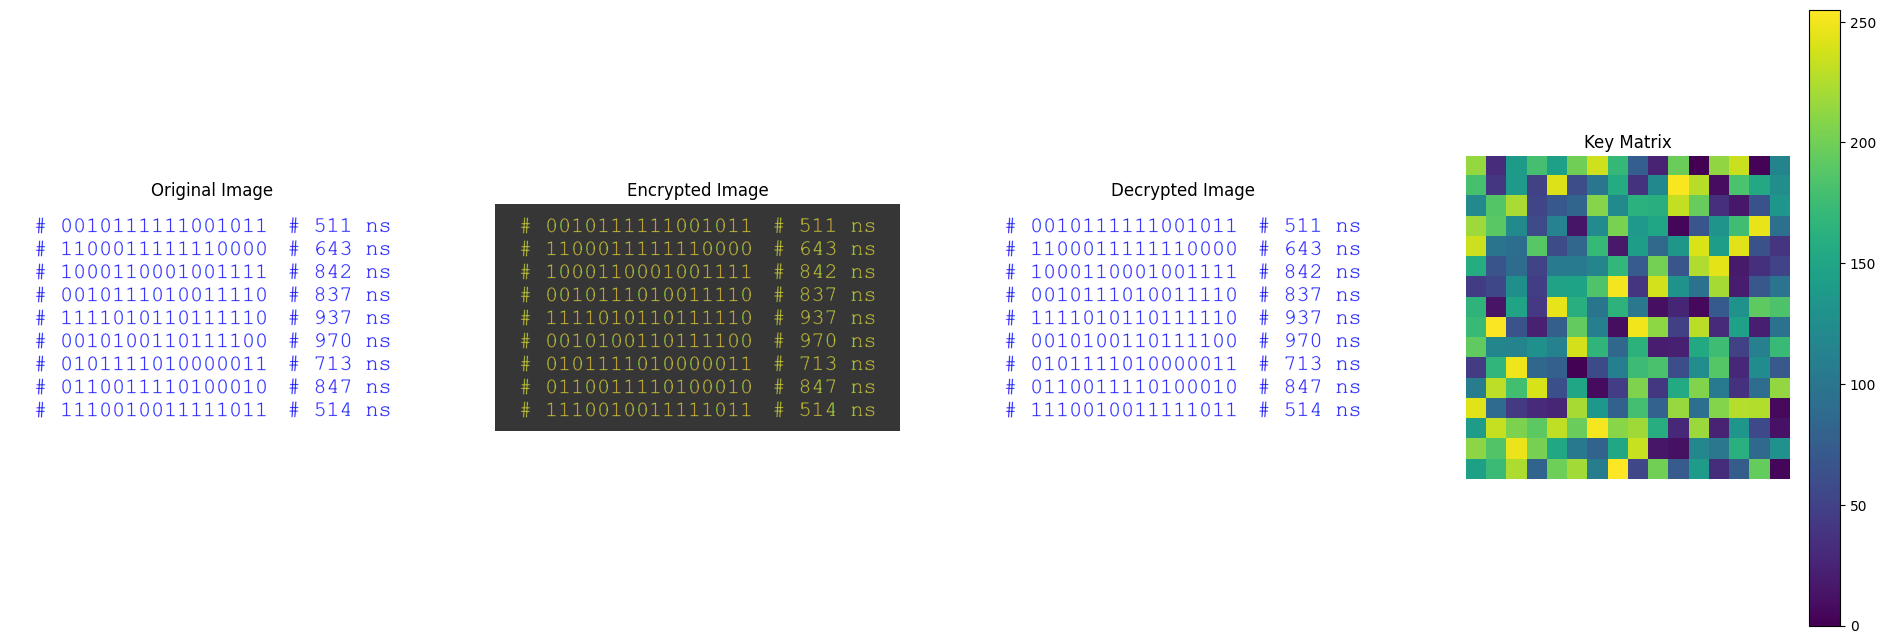

In [25]:
key_image_path = "girgit.jpg"
image_path = "binary.jpg"   
main_process(image_path, key_image_path)

Generated Key Matrix:
[[203 197 247 151 112 102 231  55 173 134  89 191 212 184  16 233]
 [135  57  11  93 219  64 157  35  78   0 248 155 234  51  99 136]
 [ 30 111 192  82 129  85  63  17 125  80 226  91  56 116 132 170]
 [175 139  83  61  24 100 140 189  19  20   4 201  88  72 237   2]
 [199  25 160  84 167 194  41 113  22  68  95 238 209 232   9 154]
 [ 69  50 105 185 182  12  37  46 205 104 156 188 222 123 240 165]
 [124  81 169 133   1 229  73 245 251 227  48  27 149 207 174 210]
 [ 38 126  33  29 239  66 183 120  21 254 255  76 196 147 150  43]
 [ 98 249 176  94 148 138  23  65 244 195 235 213 168 119 252  28]
 [ 96  18 242  15   5 216 121 177 130 106 178  52  39  47 127  36]
 [179 115 243  92 204 236 215 193 122  45  54  26  77 187  79  90]
 [ 13 217 131 225 230  49  97 221 162 152  70 180 118 158 107 211]
 [218 142 214  75 181 190  10 128  53 198 200  14 159 220 172 223]
 [ 42  31 163  74 164 110 246 153 202  67 117 186 144 206  58 101]
 [145  44 241 108 114   6  71  40 228 25

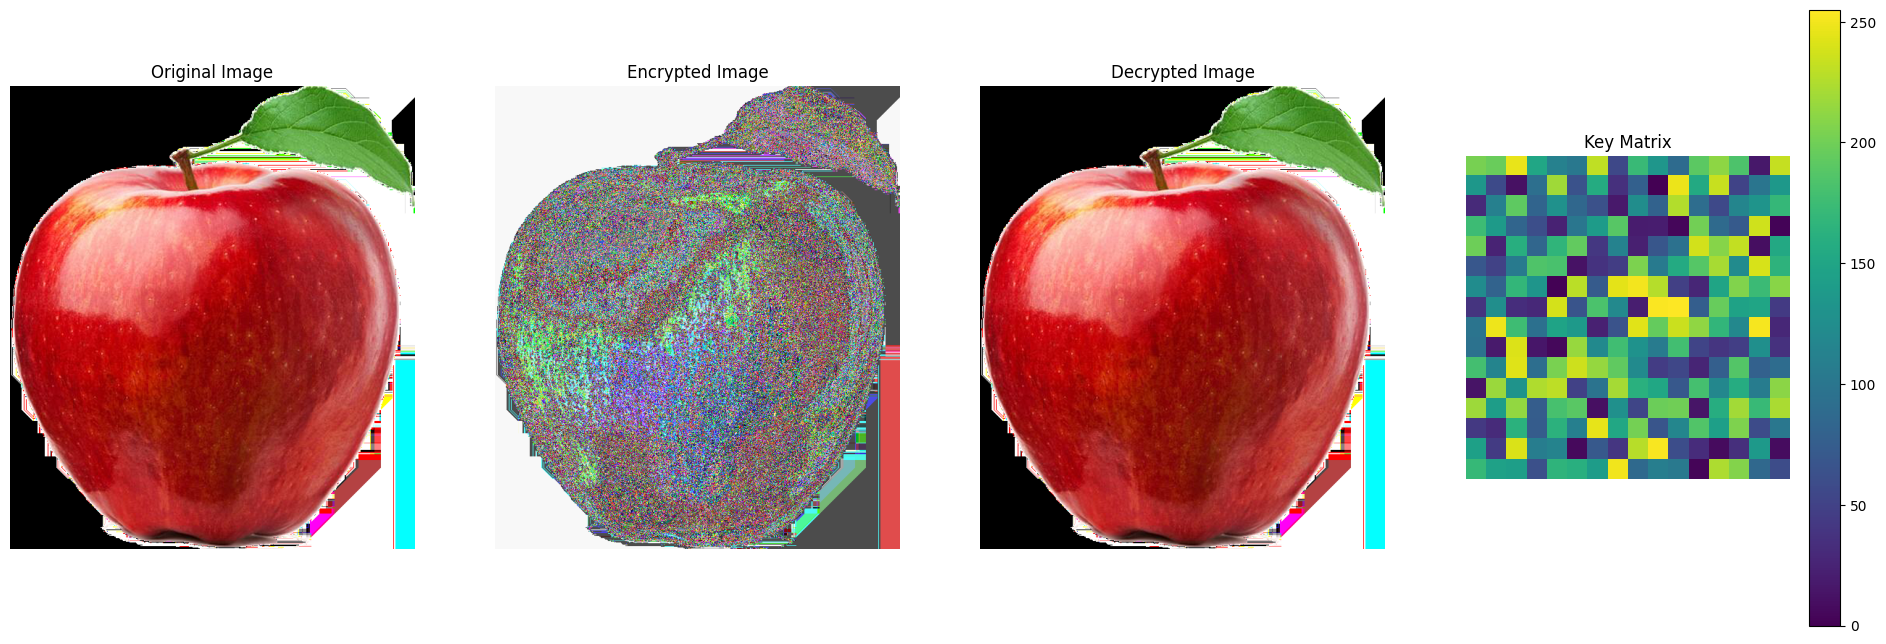

In [27]:
key_image_path = "words3.jpg"
image_path = "apple.jpg"   
main_process(image_path, key_image_path)